# Compton Edge Calibration

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize
from tqdm import tqdm

%matplotlib notebook

In [44]:
E1 = 1274.537 # gamma photopeak [keV]
Ee = 511. # m_e c^2 [keV]
Emax_real = 2*E1**2/(Ee + 2*E1)
print('Emax = ',Emax_real)

k0 = 1. # constant = pi*r_e^2/(Ee*alpha^2)

alpha = E1/Ee

# compton scattering
@np.vectorize
def real_compton(T):
    s = T/E1
    if T >= Emax_real:
        return 0
    return k0*(2. + s**2./(alpha**2*(1.-s)**2) + s/(1.-s)*(s-2./alpha))

@np.vectorize
def compton(X,sigma_reso,k=1):
    def integrand(s):
        return k0*(2. + s**2./(alpha**2*(1.-s)**2) + s/(1.-s)*(s-2./alpha))*np.exp(-(X-s)**2/(2.*sigma_reso**2))
    return k*integrate.quad(integrand,0,Emax_real/E1)[0]

# gauss function
gaus = lambda p, x: p[0]/(np.sqrt(2*np.pi)*p[2])*np.exp(-(x - p[1])**2/(2*p[2]**2))
errfunc = lambda p, x, y: gaus(p,x) - y

def chi2(errfunc,p,data_x,data_y):
    chi = 0
    if len(data_x) != len(data_y):
        print('Invalid data: x and y must have the same lenght, not %d %d' %(len(data_x),len(data_y)))
        raise TypeError
    for i,x in enumerate(data_x):
        chi += errfunc(p,x,data_y[i])**2/data_y[i] # assuming poissonian error
    dof = len(data_x) - len(p)
    
    return chi,dof


# finding the proper range of data for the gaus fit
def proper_cut(X,Y):
    max_index = np.argmax(Y)
    sig_index = 0
    for i,y in enumerate(Y[max_index:]):
        if y/Y[max_index] < np.exp(-2):
            sig_index = int(i/2)
            break
    return X[max_index-sig_index:], Y[max_index-sig_index:]

def proper_cut_and_fit(X,Y,wdx=1,wsx=1,verbose=False):
    max_index = np.argmax(Y)
    sig_index = 0
    for i,y in enumerate(Y[max_index:]):
        if y/Y[max_index] < np.exp(-2):
            sig_index = int(i/2)
            break
    if verbose:
        print('Estimated mean,sigma = ',X[max_index],X[max_index + sig_index]-X[max_index])
    nX = X[np.max((0,int(max_index-wsx*sig_index))):np.min((len(X)-1,int(max_index+wdx*sig_index)))]
    nY = Y[np.max((0,int(max_index-wsx*sig_index))):np.min((len(Y)-1,int(max_index+wdx*sig_index)))]
    
    # fit
    p0 = [np.sum(nY)*(X[1]-X[0]),X[max_index],X[max_index + sig_index]-X[max_index]]
    p1, success = optimize.leastsq(errfunc,p0[:],args=(nX,nY))
    
    return nX,nY,p1
        

Emax =  1061.7027982780808


<IPython.core.display.Javascript object>


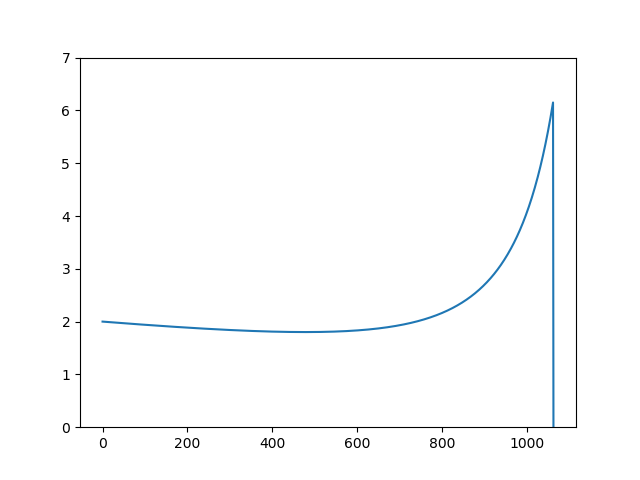

In [6]:
# real energy profile (resolution = 0)

plt.figure()
plt.ylim(0,7)
ts = np.arange(0,Emax_real+1)
rcs = real_compton(ts)

plt.plot(ts,rcs)
plt.show()

<IPython.core.display.Javascript object>


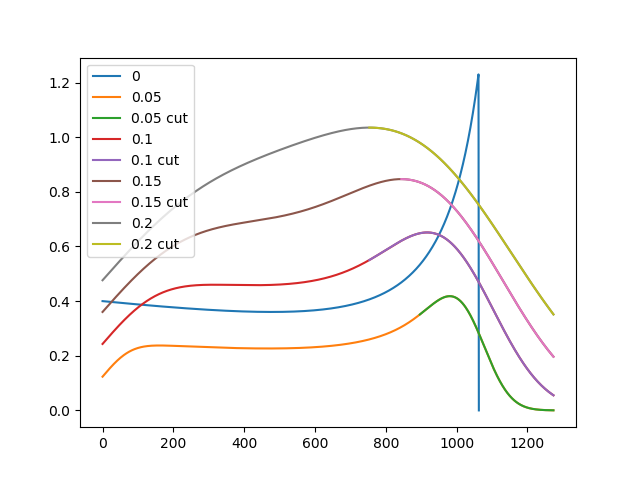

In [163]:
# energy profile with finite resolution

step = 0.001

sigmas = [0.05,0.1,0.15,0.2]
Xs = np.arange(0,1,step)

plt.figure()
ts = np.arange(0,Emax_real+1)
rcs = real_compton(ts)
plt.plot(ts,rcs/5,label='0')

for sr in sigmas:
    Cs = compton(Xs,sigma_reso=sr)
    plt.plot(Xs*E1,Cs,label=str(sr))
    nX,nC = proper_cut(Xs,Cs)
    plt.plot(nX*E1,nC,label=str(sr)+' cut')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


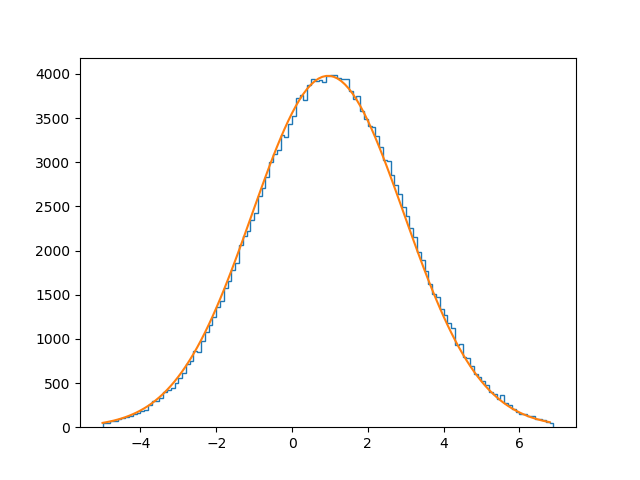

[2.00040322e+04 9.51713299e-01 2.00615109e+00] 3


(79.72951791089639, 116)

In [9]:
# testing gauss fit

p0 = [1,0,3]

ss = np.random.normal(1,2,200000)
plt.figure()
data = plt.hist(ss,bins=np.arange(-5,7,0.1),histtype='step')
plt.show()
x = data[1][:-1]
y = data[0]

p1, success = optimize.leastsq(errfunc,p0[:],args=(x,y))

plt.plot(x,gaus(p1,x))

plt.show()
print(p1,success)

chi2(errfunc,p1,x,y)

Estimated mean,sigma =  1.999999999999993 0.9999999999999787


<IPython.core.display.Javascript object>


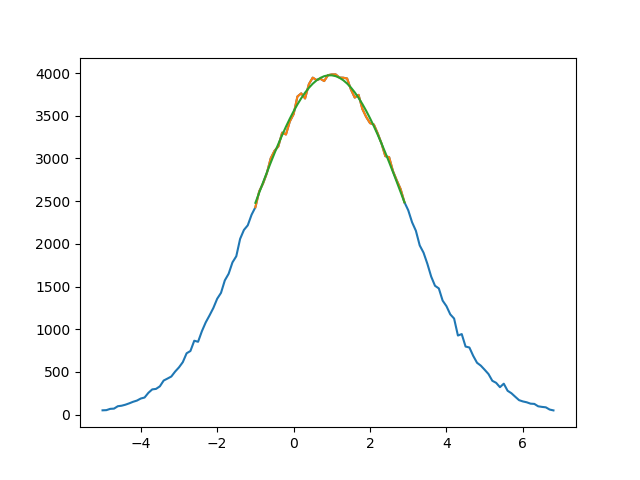

[2.00348372e+04 9.52882434e-01 2.01059018e+00]


In [25]:
newx,newy,p1 = proper_cut_and_fit(x,y,wdx=1,wsx=1)

plt.figure()
plt.plot(x,y)
plt.plot(newx,newy)
plt.plot(newx,gaus(p1,newx))
plt.show()

print(p1)

<IPython.core.display.Javascript object>


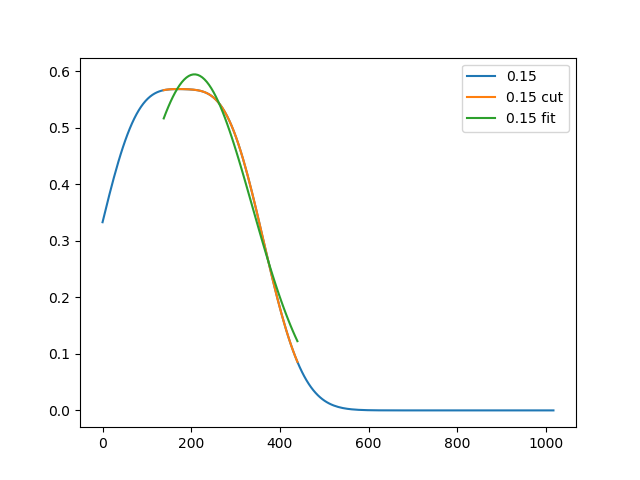

[194.80272375 207.24047141 130.64742903]


(0.11122040508996014, 57)

In [40]:
step = 0.01
sr = 0.15

Xs = np.arange(0,2,step)
Cs = compton(Xs,sigma_reso=sr)

plt.figure()
plt.plot(Xs*E1,Cs,label=str(sr))
nE,nC,p1 = proper_cut_and_fit(Xs*E1,Cs,wsx=0.2,wdx=2)
plt.plot(nE,nC,label=str(sr)+' cut')
plt.plot(nE,gaus(p1,nE),label=str(sr)+' fit')



plt.legend()
plt.show()

print(p1)
chi2(errfunc,p1,nE,nC)

46it [00:01, 38.80it/s]


<IPython.core.display.Javascript object>


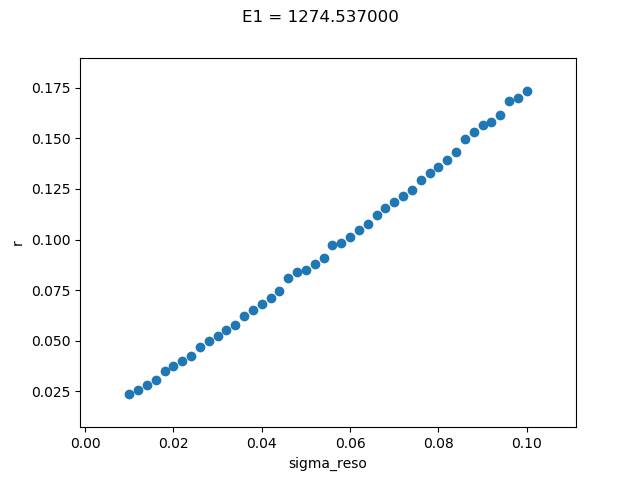

<IPython.core.display.Javascript object>


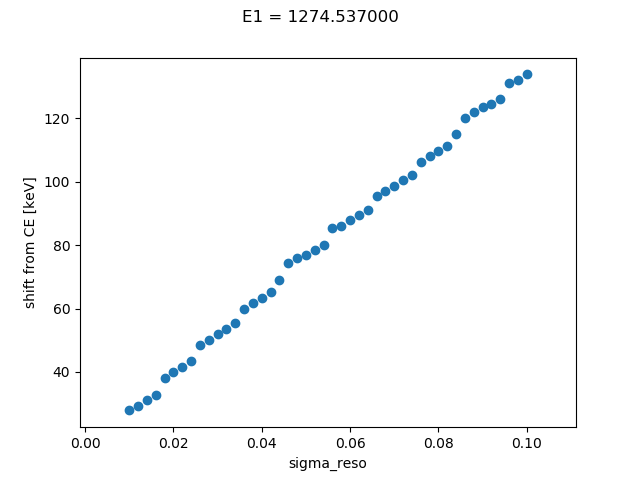

<IPython.core.display.Javascript object>


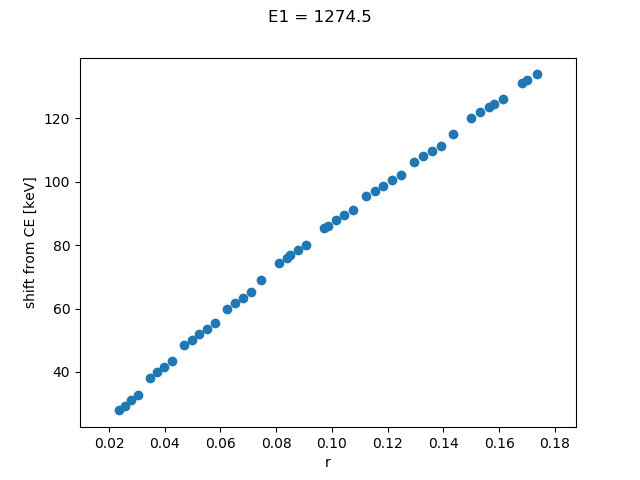

In [47]:
# finding relation between sigma_reso and resolution r=sigma/centroid

step = 0.01
Xs = np.arange(0,2,step)

sr_array = np.arange(0.01,0.1,0.002)
r_array = np.zeros_like(sr_array)
shift_array = np.zeros_like(sr_array)

for i,sr in tqdm(enumerate(sr_array)):
    Cs = compton(Xs,sigma_reso=sr)
    nE,nC,p1 = proper_cut_and_fit(Xs*E1,Cs,wsx=0.2,wdx=2)
    r_array[i] = p1[2]/p1[1]
    shift_array[i] = Emax_real - p1[1]
    

plt.figure()
plt.suptitle('E1 = %1f' %E1)
plt.xlabel('sigma_reso')
plt.ylabel('r')
plt.scatter(sr_array,r_array)
plt.show()

plt.figure()
plt.suptitle('E1 = %.3f' %E1)
plt.xlabel('sigma_reso')
plt.ylabel('shift from CE [keV]')
plt.scatter(sr_array,shift_array)
plt.show()

plt.figure()
plt.suptitle('E1 = %.3f' %E1)
plt.xlabel('r')
plt.ylabel('shift from CE [keV]')
plt.scatter(r_array,shift_array)
plt.show()